# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

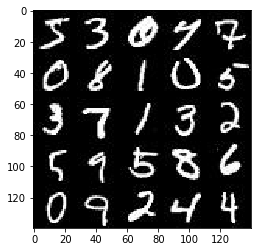

In [2]:
## I had to move this section here so I don't have to pull the data again
data_dir = './data'
import helper
import numpy as np
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

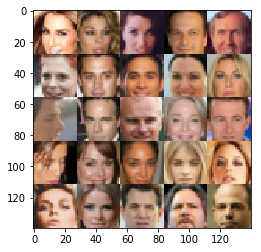

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/anaconda3/envs/dog-project/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input')
    z_data = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_data')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    
    def layer(val, filt, shape, strides, normalize=True):
        layer = tf.layers.conv2d(val, filt, shape, strides, padding='same')
        if (normalize == True):
            layer = tf.layers.batch_normalization(layer, training=True)
        
        layer = tf.maximum(alpha * layer, layer)
        
        return layer
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        hl_1 = layer(images, 128, 5, 2, normalize=False)
        hl_2 = layer(hl_1, 256, 5, 2)
        hl_3 = layer(hl_2, 512, 5, 2)
        
        
        flat = tf.reshape(hl_3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        
        # passing the fully connected layer through the sigmoid function to make sure
        # it returns one for real image and zero for fake images
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    
    def layer(val, filt, shape, strides):
        layer = tf.layers.conv2d_transpose(val, filt, shape, strides, padding='SAME')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.maximum(alpha * layer, layer)
        
        return layer
    
    with tf.variable_scope("generator", reuse=not is_train):
        
        h1 = tf.layers.dense(z, 7*7*512)
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = layer(h1, 256, 5, 1)
        h3 = layer(h2, 128, 5, 2)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, padding='SAME')
        output = tf.tanh(logits)
        
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


## Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    model = generator(input_z, out_channel_dim)
    
    discriminator_real_model, discriminator_real_logits = discriminator(input_real)
    discriminator_dum_model, discriminator_dum_logits = discriminator(model, True)
    
    # Getting one for real images
    discriminator_r_param = tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_real_logits, labels=tf.ones_like(discriminator_real_logits)*np.random.uniform(0.7, 1.2))
    discriminator_real_loss = tf.reduce_mean(discriminator_r_param)
    
    # Getting zero for fake images
    discriminator_d_param = tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_dum_logits, labels=tf.zeros_like(discriminator_dum_logits)*np.random.uniform(0.0, 0.3))
    discriminator_dum_loss = tf.reduce_mean(discriminator_d_param)
    
    # The total lost for the discriminator is the sum of lost for the real and the fake images
    discriminator_loss = discriminator_real_loss + discriminator_dum_loss
    
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_dum_logits, labels=tf.ones_like(discriminator_dum_model)))
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    #get the trainable variables from my Graph
    t_vars = tf.trainable_variables()
    
    # Getting discriminator trainable variables from t_vars
    discriminator_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # Getting generator trainable variables from t_vars
    generator_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)
            
        return d_opt, g_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np


def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import matplotlib.pyplot as plt
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    loss_list = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                loss_list.append([d_loss.eval({input_z: batch_z, input_real: batch_images}), g_loss.eval({input_z: batch_z})])
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                #print(loss_list)
                if steps % show_every == 0:
                    # reusing the show_n_images variable declared and initialized earlier to create the grid
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                    
        plt.plot(loss_list, label='Discriminator')
        plt.plot(loss_list, label='generator')
        plt.ylabel('Loss')
        plt.xlabel('Steps')
        plt.title("Loss Graph")
        plt.show()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [12]:
batch_size = 16
z_dim = 64
learning_rate = 0.0002
beta1 = 0.3
print_every = 10
show_every = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 6.3513... Generator Loss: 13.5809


KeyboardInterrupt: 

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.0736... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 1.2445
Epoch 1/1... Discriminator Loss: 3.0020... Generator Loss: 7.2845
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 2.2549
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 1.7548
Epoch 1/1... Discriminator Loss: 1.9395... Generator Loss: 6.7028
Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 3.9408
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 3.0440
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 1.3380
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 3.1757


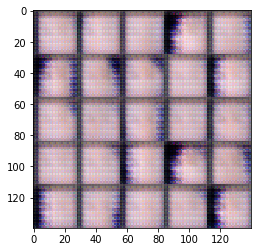

Epoch 1/1... Discriminator Loss: 2.8552... Generator Loss: 0.1895
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.7264
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 2.1956
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.9827
Epoch 1/1... Discriminator Loss: 0.5934... Generator Loss: 1.9940
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 0.5662... Generator Loss: 1.8936
Epoch 1/1... Discriminator Loss: 0.4705... Generator Loss: 2.9188


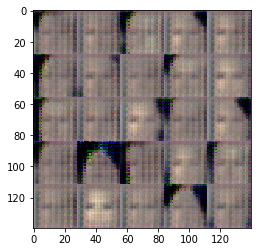

Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 2.5736
Epoch 1/1... Discriminator Loss: 0.3888... Generator Loss: 5.8033
Epoch 1/1... Discriminator Loss: 0.4386... Generator Loss: 3.6829
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 2.6344
Epoch 1/1... Discriminator Loss: 0.6042... Generator Loss: 2.3062
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 4.7373
Epoch 1/1... Discriminator Loss: 0.5400... Generator Loss: 3.0811
Epoch 1/1... Discriminator Loss: 0.5787... Generator Loss: 2.6461
Epoch 1/1... Discriminator Loss: 0.4320... Generator Loss: 4.1948


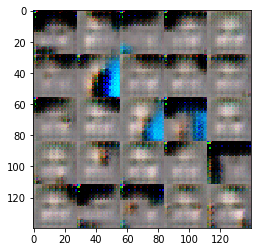

Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 2.4491
Epoch 1/1... Discriminator Loss: 0.5720... Generator Loss: 3.7645
Epoch 1/1... Discriminator Loss: 0.4932... Generator Loss: 2.8977
Epoch 1/1... Discriminator Loss: 0.5724... Generator Loss: 2.1010
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 1.5793
Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 1.9107
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 1.8302
Epoch 1/1... Discriminator Loss: 2.3704... Generator Loss: 0.2682
Epoch 1/1... Discriminator Loss: 0.4324... Generator Loss: 3.6477


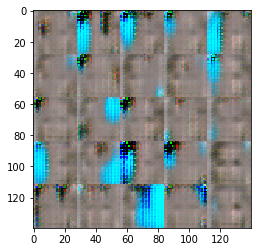

Epoch 1/1... Discriminator Loss: 0.6028... Generator Loss: 1.9355
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 2.3433
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 1.6277
Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 2.8361
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 3.0835
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 1.8451
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 2.2529
Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 1.5260


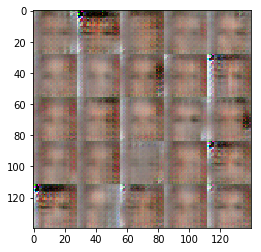

Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 2.2139
Epoch 1/1... Discriminator Loss: 0.4521... Generator Loss: 9.5132
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 2.0906
Epoch 1/1... Discriminator Loss: 0.4231... Generator Loss: 3.8062
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.2335
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.9050


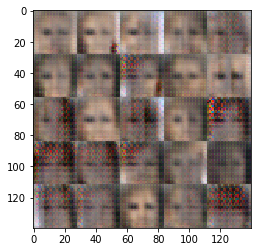

Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 1.3428
Epoch 1/1... Discriminator Loss: 0.4742... Generator Loss: 3.8900
Epoch 1/1... Discriminator Loss: 2.2244... Generator Loss: 2.0998
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 1.1867
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 1.7217
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 1.3364
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 1.2449
Epoch 1/1... Discriminator Loss: 0.9419... Generator Loss: 1.8857


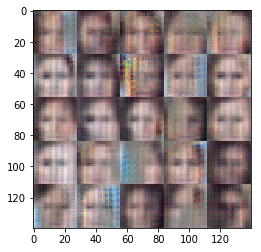

Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.4778
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 1.5830
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 1.1322
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 1.7356
Epoch 1/1... Discriminator Loss: 2.5758... Generator Loss: 0.2827
Epoch 1/1... Discriminator Loss: 0.8780... Generator Loss: 1.1618
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 1.2289


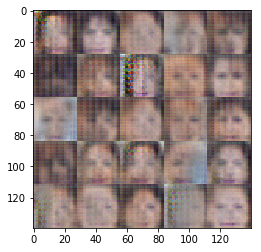

Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 2.7027
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.3562
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 0.7574... Generator Loss: 1.3962
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 1.1162
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.1702
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 1.0270
Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 5.1668
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.7435


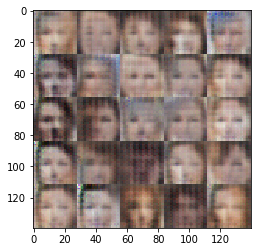

Epoch 1/1... Discriminator Loss: 0.8434... Generator Loss: 1.1559
Epoch 1/1... Discriminator Loss: 0.6413... Generator Loss: 1.8406
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 1.1744
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 1.5882
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 1.3687
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 2.7657
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 1.7925
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 2.5904
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 1.4784
Epoch 1/1... Discriminator Loss: 1.6783... Generator Loss: 0.5012


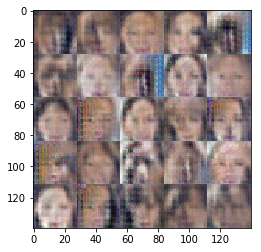

Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 1.4858
Epoch 1/1... Discriminator Loss: 0.6563... Generator Loss: 1.7606
Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 1.7379
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.0512
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 1.5839
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.0865
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 1.2338
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6633


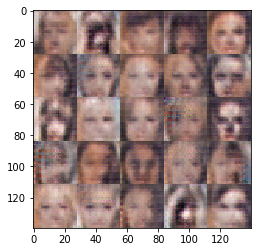

Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 1.1989
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 0.6160... Generator Loss: 2.0956
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 2.2330
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 2.6866
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 0.9709... Generator Loss: 1.8368
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 1.3599
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 2.1802


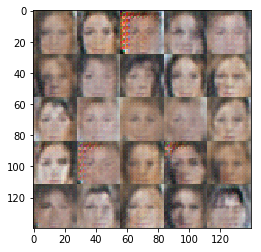

Epoch 1/1... Discriminator Loss: 1.7448... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 0.6607... Generator Loss: 2.3789
Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 1.7808
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.4385
Epoch 1/1... Discriminator Loss: 0.4447... Generator Loss: 3.1106
Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 1.5359
Epoch 1/1... Discriminator Loss: 0.6969... Generator Loss: 3.2923
Epoch 1/1... Discriminator Loss: 0.4260... Generator Loss: 3.2735


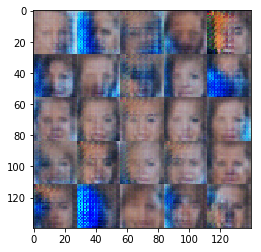

Epoch 1/1... Discriminator Loss: 0.8384... Generator Loss: 1.8175
Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 2.2752
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 0.7076... Generator Loss: 1.5923
Epoch 1/1... Discriminator Loss: 0.5770... Generator Loss: 2.0694
Epoch 1/1... Discriminator Loss: 0.5711... Generator Loss: 1.9108
Epoch 1/1... Discriminator Loss: 0.6458... Generator Loss: 1.5908
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.2075
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 1.7248


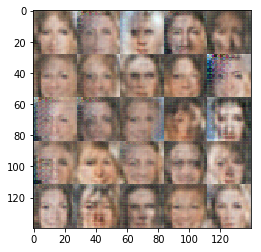

Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.7724
Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 1.2262
Epoch 1/1... Discriminator Loss: 0.7854... Generator Loss: 1.9628
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 1.2952
Epoch 1/1... Discriminator Loss: 0.8133... Generator Loss: 1.5447
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 1.9421
Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 1.3716
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.2560
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 1.0179
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.8605


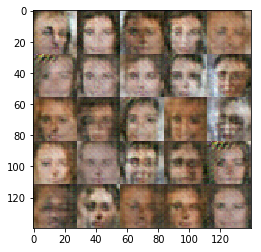

Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.6990
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 1.0660
Epoch 1/1... Discriminator Loss: 1.9603... Generator Loss: 3.6369
Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 1.3906
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 2.1361
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 1.0307


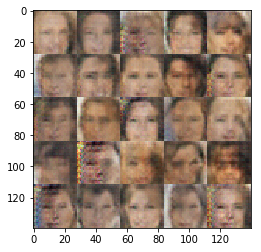

Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 1.5853
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 1.7336
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 0.8118... Generator Loss: 1.2623
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.8542
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 2.0494


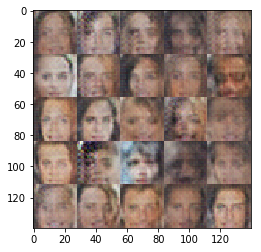

Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.2998
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 1.1054
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.6386
Epoch 1/1... Discriminator Loss: 0.8802... Generator Loss: 1.4491
Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 1.1474
Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 1.4482
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.4303
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 1.1010


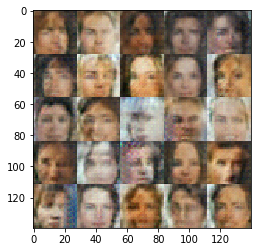

Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 1.2103
Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 1.3690
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 1.3755
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 1.0778
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 1.2934
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 1.0250
Epoch 1/1... Discriminator Loss: 0.8562... Generator Loss: 1.2370
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.2385
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 1.0127


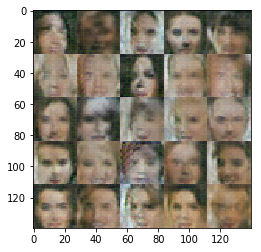

Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 1.3835
Epoch 1/1... Discriminator Loss: 0.7659... Generator Loss: 1.9209
Epoch 1/1... Discriminator Loss: 0.9373... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 1.4177
Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 1.4070
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 1.1974
Epoch 1/1... Discriminator Loss: 0.8085... Generator Loss: 1.2152


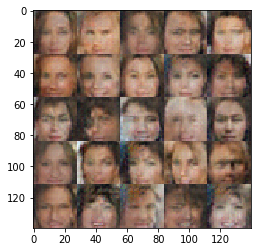

Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.2683
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 1.8538
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 1.3315
Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 1.8480
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 1.2462
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 1.2432
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 1.3168


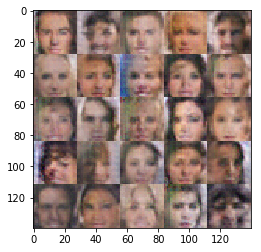

Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 1.7441
Epoch 1/1... Discriminator Loss: 0.7825... Generator Loss: 1.5163
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 1.4901
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.1648
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 0.9398
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.5287
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 1.4449


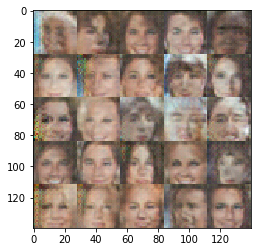

Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.2528
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 1.3241
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 1.6877
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 1.2330
Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 1.3206
Epoch 1/1... Discriminator Loss: 2.0360... Generator Loss: 2.6791
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 1.0789


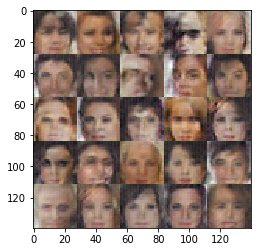

Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 1.0914
Epoch 1/1... Discriminator Loss: 1.7271... Generator Loss: 0.3905
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 1.0238
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7951


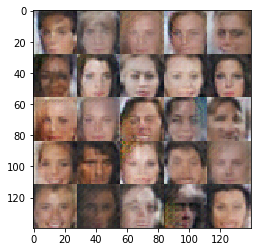

Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 1.2440
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 1.1340
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.6886


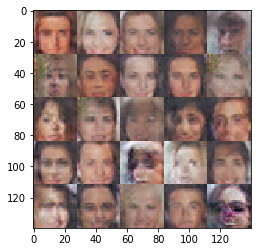

Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 1.1073
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.9825


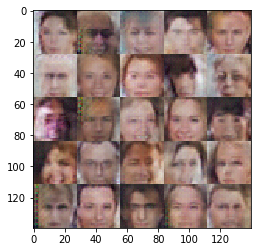

Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.9970
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.9948
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 1.1688


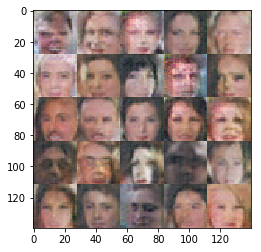

Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 1.1764
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 1.1209
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 1.1267
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 1.7674
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 1.0330


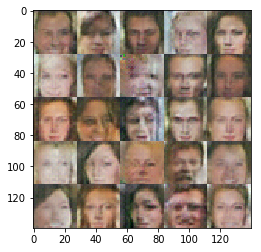

Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 1.2055
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 1.2795
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 1.1620
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 1.1679
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.5637... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 1.0488


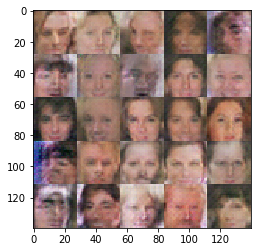

Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.0717
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 2.0549
Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 1.1636
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 1.6880
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.4384
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.0628


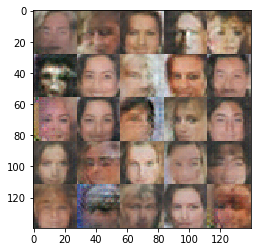

Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 1.2070
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 1.3211
Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 1.3206
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 1.5829
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 1.6555
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 1.0321


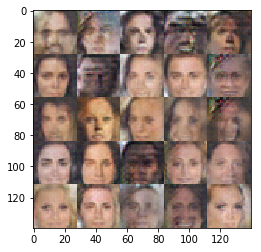

Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.5687... Generator Loss: 0.5308
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 1.3484


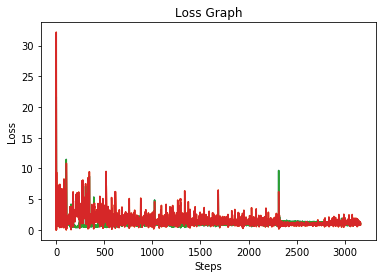

In [13]:
batch_size = 16
z_dim = 64
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.